In [ ]:
#Download dataset from Kaggle
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download daffafauzanazhari/bruised-facememar

 98% 244M/248M [00:05<00:00, 48.9MB/s]
100% 248M/248M [00:05<00:00, 46.7MB/s]


In [ ]:
! chmod 600 kaggle.json

In [ ]:
#import library

import os
import zipfile
import random
import tensorflow as tf
import csv
import numpy as np
import shutil
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

from tqdm import tqdm

In [ ]:
!ls

bruised-facememar.zip  kaggle.json  sample_data  saved_model


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [ ]:
#Dataset being extract and placed in directory
path_memar_and_nonmemar = f"{getcwd()}/bruised-facememar.zip"
#shutil.rmtree('/tmp')

local_zip = path_memar_and_nonmemar
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall('/tmp')
zip_ref.close()



In [ ]:
!ls

bruised-facememar.zip  kaggle.json  sample_data  saved_model


In [ ]:
# Dataset amount
print(len(os.listdir("/tmp/dataset/dataset/memar")))
print(len(os.listdir("/tmp/dataset/dataset/non-memar")))

92
113


In [ ]:
try:
  os.mkdir("/tmp/violence-v-nonviolence/")
  os.mkdir("/tmp/violence-v-nonviolence/training/")
  os.mkdir("/tmp/violence-v-nonviolence/testing/")
  os.mkdir("/tmp/violence-v-nonviolence/training/violence/")
  os.mkdir("/tmp/violence-v-nonviolence/training/nonviolence/")
  os.mkdir("/tmp/violence-v-nonviolence/testing/violence/")
  os.mkdir("/tmp/violence-v-nonviolence/testing/nonviolence/")
except OSError:
  pass

In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    source_list = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

    for file_number in range(len(source_list)):
          file_source = os.path.join(SOURCE, source_list[file_number-1])
          file_training = os.path.join(TRAINING, source_list[file_number-1])
          file_validation = os.path.join(TESTING, source_list[file_number-1])

          size = os.path.getsize(file_source)

          if (file_number)<(len(source_list)*SPLIT_SIZE):
              if size > 0:
                  copyfile(file_source, file_training)
          elif size > 0:
              copyfile(file_source, file_validation)
              
VIOLENCE_SOURCE_DIR = "/tmp/dataset/dataset/memar/"
TRAINING_VIOLENCE_DIR = "/tmp/violence-v-nonviolence/training/violence/"
TESTING_VIOLENCE_DIR = "/tmp/violence-v-nonviolence/testing/violence/"
NONVIOLENCE_SOURCE_DIR = "/tmp/dataset/dataset/non-memar/"
TRAINING_NONVIOLENCE_DIR = "/tmp/violence-v-nonviolence/training/nonviolence/"
TESTING_NONVIOLENCE_DIR = "/tmp/violence-v-nonviolence/testing/nonviolence/"

split_size = .7
split_data(VIOLENCE_SOURCE_DIR, TRAINING_VIOLENCE_DIR, TESTING_VIOLENCE_DIR, split_size)
split_data(NONVIOLENCE_SOURCE_DIR, TRAINING_NONVIOLENCE_DIR, TESTING_NONVIOLENCE_DIR, split_size)

In [ ]:
print(len(os.listdir("/tmp/violence-v-nonviolence/training/violence/")))
print(len(os.listdir("/tmp/violence-v-nonviolence/training/nonviolence/")))
print(len(os.listdir("/tmp/violence-v-nonviolence/testing/violence/")))
print(len(os.listdir("/tmp/violence-v-nonviolence/testing/nonviolence/")))

91
108
59
70


In [ ]:
do_fine_tuning = False

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [ ]:
model = tf.keras.Sequential([feature_extractor,
                             tf.keras.layers.Dense(1,activation="softmax")])

model.summary()

model.compile(optimizer=RMSprop(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
TRAINING_DIR ="/tmp/violence-v-nonviolence/training/"
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range =40,
    width_shift_range =0.2,
    height_shift_range = 0.2,
    shear_range =0.2,
    zoom_range =0.2,
    horizontal_flip =True,
    fill_mode = "nearest")

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size=10, class_mode="binary", target_size=(224,224))

VALIDATION_DIR ="/tmp/violence-v-nonviolence/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, batch_size=10, class_mode="binary", target_size=(224,224))

Found 199 images belonging to 2 classes.
Found 129 images belonging to 2 classes.


In [ ]:
history = model.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=validation_generator)


Epoch 1/20
20/20 [==============================] - 29s 1s/step - loss: 0.6139 - acc: 0.4573 - val_loss: 0.4955 - val_acc: 0.4574
Epoch 2/20
20/20 [==============================] - 24s 1s/step - loss: 0.4061 - acc: 0.4573 - val_loss: 0.3803 - val_acc: 0.4574
Epoch 3/20
20/20 [==============================] - 25s 1s/step - loss: 0.3014 - acc: 0.4573 - val_loss: 0.2666 - val_acc: 0.4574
Epoch 4/20
20/20 [==============================] - 25s 1s/step - loss: 0.2267 - acc: 0.4573 - val_loss: 0.2135 - val_acc: 0.4574
Epoch 5/20
20/20 [==============================] - 25s 1s/step - loss: 0.1856 - acc: 0.4573 - val_loss: 0.1641 - val_acc: 0.4574
Epoch 6/20
20/20 [==============================] - 24s 1s/step - loss: 0.1324 - acc: 0.4573 - val_loss: 0.1373 - val_acc: 0.4574
Epoch 7/20
20/20 [==============================] - 24s 1s/step - loss: 0.1045 - acc: 0.4573 - val_loss: 0.1012 - val_acc: 0.4574
Epoch 8/20
20/20 [==============================] - 24s 1s/step - loss: 0.1014 - acc: 0.45

Text(0.5, 1.0, 'Training and validation loss')

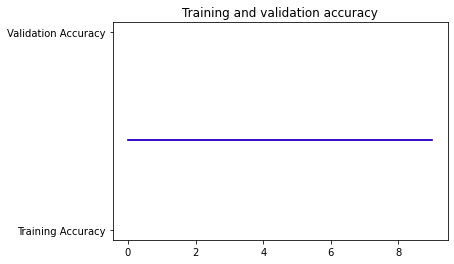

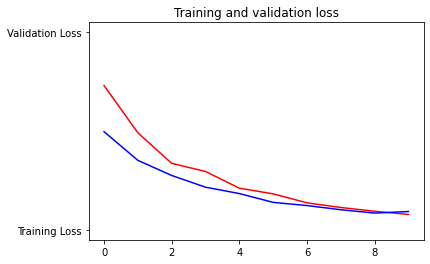

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
SAVED_MODEL = "saved_model"

In [ ]:
tf.saved_model.save(model, SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
loaded = tf.saved_model.load(SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_2_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_2_input')})
{'dense_3': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_3')}


In [ ]:
image_shape = (224,224,3)

In [ ]:
def representative_dataset():
  for i in range(100):
    image = tf.random.normal([1] + list(image_shape))
    yield [image]

In [ ]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_dataset)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.uint8
converter.inference_output_type = tf.uint8  # or tf.uint8
#tflite_quant_model = converter.convert()

In [ ]:
tflite_model = converter.convert()
open('FinalCapstone.tflite', 'wb').write(tflite_model)

2715112

In [ ]:
labels = ['violence', 'nonviolence']

with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

In [ ]:
try:
    from google.colab import files
    files.download('FinalCapstone.tflite')
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loaded = tf.saved_model.load(tflite_model)

UnicodeDecodeError: ignored

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_2_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_2_input')})
{'dense_3': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_3')}


In [ ]:

interpreter = tf.lite.Interpreter(model_path = SAVED_MODEL)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

ValueError: ignored

Text(0.5, 1.0, 'Training and validation loss')

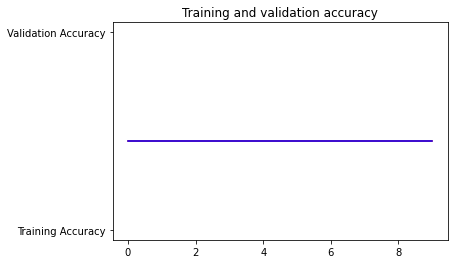

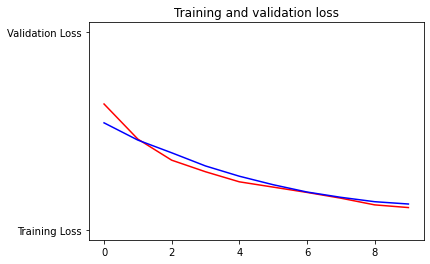

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a violence")
    
  else:
    print(fn + " is a non violence")
 

Saving fb178f32-65a8-4c98-8b28-e6e159674cb8-Noah.jpg to fb178f32-65a8-4c98-8b28-e6e159674cb8-Noah.jpg
[1.]
fb178f32-65a8-4c98-8b28-e6e159674cb8-Noah.jpg is a violence
